# Complex call center model

## Importing modules

In [1]:
# Simulator
from queuesim import Simulator

# Station types
from queuesim.stations import Source, Process, Decide, Delay, Dispose

# Pseudo random number generators
from queuesim.random_dist import exp as dist_exp

# Print results
from queuesim.models import call_center_results

# Plot model
from queuesim import build_graph
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Defining general plot style
sns.set()

## Model

<pre><code>
             -------------
             v           |
 Source -> Process -> Forward -> Dispose
           ^    |                   ^
           |   Retry ---------------|
           |    v
           |-- Delay
</code></pre>

This model can also be simulated via this online simulator:
<https://a-herzog.github.io/MiniSimulator/>

## Model parameters

In [2]:
# Arrivals to be simulated
count = 100_000

# Arrival process
mean_i = 100
get_i = dist_exp(mean_i)
get_ib = None  # Batch arrivals

# Service process
mean_s = 80
get_s = dist_exp(mean_s)
b = 1  # Service batch size

# Post-processing times
get_s2 = None

# Impatience
mean_nu = 900
get_nu = None  # None = no impatience

# Retry process
retry_rate = 0
mean_retry_delay = 900
get_retry_delay = dist_exp(mean_retry_delay)

# Number of operators
c = 1

# System size
K = -1  # -1 stands for "unlimited"

# FIFO or LIFO client selection
LIFO = False

# Forwarding
forwarding_rate = 0

In the model abpove many of the possible properties are not activated (like retry, forwardning, batching etc.). Also only the exponential distribution is used. So this just a M/M/c model with mit E[I]=100, E[S]=80 and c=1. This can be solved analytically. The results are:

* Mean waiting time: E[W]=320
* Mean service time: E[S]=80 (just defined above)
* Mean residence time: E[V]=E[W]+E[S]=400
* Mean queue length: E[N<sub>Q</sub>]=3,2
* Mean number of clients in the system: E[N]=4
* Utilization: &rho;=80%

Try changing some of the model parameters and see what happens in each case compared to the Erlang C base model.

## Define stations

In [3]:
simulator = Simulator()
source = Source(simulator, count, get_i, get_ib)
process = Process(simulator, get_s, c, get_nu, get_s2, K, b, LIFO)
forwarding = Decide(simulator)
retry = Decide(simulator)
delay = Delay(simulator, get_retry_delay)
dispose = Dispose(simulator)

## Link stations

In [4]:
source.set_next(process)
process.set_next(forwarding)
process.set_next_cancel(retry)
forwarding.add_next(dispose, 1 - forwarding_rate)
forwarding.add_next(process, forwarding_rate)
retry.add_next(dispose, 1 - retry_rate)
retry.add_next(delay, retry_rate)
delay.set_next(process)

## Run simulation

In [5]:
simulator.run()

## Show results

In [6]:
print(call_center_results(source, process, forwarding, retry, delay, dispose, simulator))

System
  Simulated arrivals: 100000
  Inter-arrival times at the system (I): count = 100000, mean = 99.8, sd = 100.2, cv = 1.0, min = 0.0, max = 719.6
  Inter-departure times from the system (ID): count = 100000, mean = 99.8, sd = 100.0, cv = 1.0, min = 0.0, max = 581.1

Process station
  Success rate: count = 100000, Success = 100.0%
  Waiting times (W): count = 100000, mean = 319.2, sd = 392.2, cv = 1.2, min = 0.0, max = 2074.8
  Service times (S): count = 100000, mean = 80.1, sd = 80.1, cv = 1.0, min = 0.0, max = 578.7
  Queue length (NQ): timspan = 9981765.1, mean = 3.2, min = 0.0, max = 42.0
  Clients at the station (N): timspan = 9981765.1, mean = 4.0, min = 0.0, max = 43.0
  Work load (c*rho): timspan = 9981765.1, mean = 0.8, min = 0.0, max = 1.0

Clients
  Waiting times (W): count = 100000, mean = 319.2, sd = 392.2, cv = 1.2, min = 0.0, max = 2074.8
  Service times (S): count = 100000, mean = 80.1, sd = 80.1, cv = 1.0, min = 0.0, max = 578.7
  Residence times (V): count = 10000

## Queueing network model

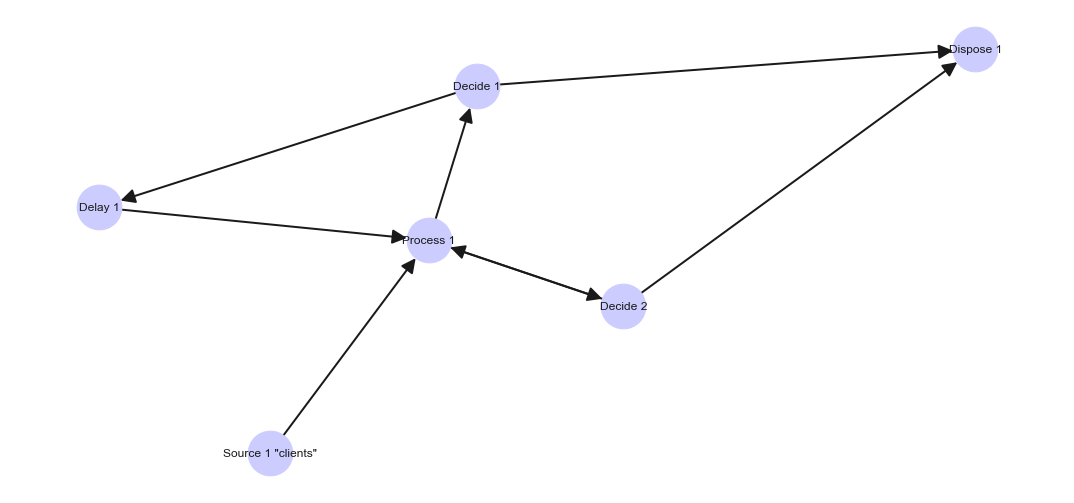

In [7]:
dg = build_graph([source])
fig, ax = plt.subplots(figsize=(19, 9))
nx.draw(dg, ax=ax, with_labels=True, node_color='#CCCCFF', node_size=2000, arrowsize=30, width=2)